In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

In [2]:
warnings.filterwarnings("ignore")

obs_start = '2020-01-01'; obs_end = '2023-12-31'
sessions = (
    pd.read_csv('../../data/sessions.csv', parse_dates=['event_date'])
      .query('event_date >= @obs_start and event_date <= @obs_end')
)
transactions = (
    pd.read_csv('../../data/transactions.csv', parse_dates=['event_date'])
     .query('event_date >= @obs_start and event_date <= @obs_end')
    )
prod_cat = pd.read_csv("../../data/product_categories.csv")

In [3]:
# filter sessions
is_amz = sessions['domain_name'].str.contains('amazon', case=False, na=False)
sessions_amz     = sessions[is_amz]
sessions_non_amz = sessions[~is_amz]

# filter transactions
is_amz_tx = transactions['domain_name'].str.contains('amazon', case=False, na=False)
transactions_amz     = transactions[is_amz_tx]
transactions_non_amz = transactions[~is_amz_tx]


In [4]:
sessions_amz = sessions_amz.drop_duplicates().reset_index()
sessions_non_amz = sessions_non_amz.drop_duplicates().reset_index()
transactions_amz = transactions_amz.drop_duplicates().reset_index()
transactions_non_amz = transactions_non_amz.drop_duplicates().reset_index()

In [5]:
s_mach_amz = sessions_amz['machine_id'].unique().tolist()
t_mach_amz = transactions_amz['machine_id'].unique().tolist()

In [6]:
sessions_amz = sessions_amz[sessions_amz['machine_id'].isin(t_mach_amz)]

In [7]:
def bucket_ref(ref):
    if pd.isna(ref):
        return 'direct'
    r = ref.lower()
    # search engines
    if any(x in r for x in ['google','bing','yahoo']):
        return 'search'
    # social media
    if any(x in r for x in ['facebook','twitter','instagram','pinterest']):
        return 'social'
    # major marketplaces
    if any(x in r for x in ['amazon.', 'ebay.', 'walmart.', 'etsy.', 'target.']):
        return 'marketplace'
    return 'other'

sessions_amz['ref_bucket'] = sessions_amz['ref_domain__name'].apply(bucket_ref)


### Extracting Temporal Features

In [8]:
# extract hour and weekday
sessions_amz['event_date'] = pd.to_datetime(sessions_amz['event_date'])

# extract hour by splitting on ':' and converting to int
sessions_amz['event_time_parsed'] = pd.to_datetime(
    sessions_amz['event_time'],
    format='%H:%M:%S',
    errors='coerce'            # invalid/missing → NaT
)
sessions_amz['hour'] = sessions_amz['event_time_parsed'].dt.hour

# extract weekday name
sessions_amz['weekday'] = sessions_amz['event_date'].dt.day_name()


# extract month name
sessions_amz['month'] = sessions_amz['event_date'].dt.month_name()

### Extracting Demographic Features

In [9]:
sessions_agg = sessions_amz.groupby(['machine_id','event_date']).agg(
    pages_viewed       = ('pages_viewed',       'sum'),
    duration           = ('duration',           'sum'),
    hoh_most_education = ('hoh_most_education', 'first'),
    census_region      = ('census_region',      'first'),
    household_size     = ('household_size',     'first'),
    hoh_oldest_age     = ('hoh_oldest_age',     'first'),
    household_income   = ('household_income',   'first'),
    children           = ('children',           'first'),
    hour = ('hour', 'first'),
    month = ('month', 'first'),
    weekday = ('weekday', 'first'),
    ref_bucket=('ref_bucket', 'first')
).reset_index()

In [10]:
trans_agg = (
    transactions_amz
    .groupby(['machine_id','event_date'])
    .size()
    .reset_index(name='converted')
)
trans_agg['converted'] = 1

In [11]:
df = sessions_agg.merge(
    trans_agg, 
    on=['machine_id','event_date'], 
    how='left'
)
df['converted'] = df['converted'].fillna(0).astype(int)

### Feature Engineering

Days since Last Purchase was made

In [12]:
df = df.sort_values(['machine_id','event_date'])

def compute_days_since_last(group):
    group = group.sort_values('event_date').copy()
    prev_date = None
    prev_conv = None
    prev_days = 0
    days = []
    for _, row in group.iterrows():
        if prev_date is None:
            days.append(0)
        else:
            diff = (row['event_date'] - prev_date).days
            days.append(diff if prev_conv==1 else prev_days + diff)
        prev_date = row['event_date']
        prev_conv = row['converted']
        prev_days = days[-1]
    group['days_since_last_purchase'] = days
    return group

df = df.groupby('machine_id').apply(compute_days_since_last).reset_index(drop=True)


In [13]:
df.isna().sum()

machine_id                      0
event_date                      0
pages_viewed                    0
duration                        0
hoh_most_education          10585
census_region               18684
household_size              39958
hoh_oldest_age              13166
household_income            24172
children                     2716
hour                         3943
month                           0
weekday                         0
ref_bucket                      0
converted                       0
days_since_last_purchase        0
dtype: int64

Handling Missing Values

In [14]:
df['hoh_most_education'].fillna(99, inplace=True)
df['census_region'].fillna(99, inplace=True)
df['household_size'].fillna(99, inplace=True)
df['hoh_oldest_age'].fillna(99, inplace=True)
df['household_income'].fillna(99, inplace=True)

In [15]:
df['hoh_most_education'] = df['hoh_most_education'].replace(-88, 99)
df['household_size'] = df['household_size'].replace(-88, 99)

In [16]:
df = df.dropna().reset_index(drop=True)

In [17]:
df.isna().sum()

machine_id                  0
event_date                  0
pages_viewed                0
duration                    0
hoh_most_education          0
census_region               0
household_size              0
hoh_oldest_age              0
household_income            0
children                    0
hour                        0
month                       0
weekday                     0
ref_bucket                  0
converted                   0
days_since_last_purchase    0
dtype: int64

In [18]:
df.shape

(3996279, 16)

In [19]:
df['converted'].value_counts()

converted
0    3454989
1     541290
Name: count, dtype: int64

In [20]:
cat_cols = ['weekday', 'hour', 'month', 'ref_bucket',
            'hoh_most_education', 'household_income', 'census_region', 'household_size', 'hoh_oldest_age', 'children']
num_cols = ['pages_viewed', 'duration',  'days_since_last_purchase']


In [21]:
model_df = df.copy()

### Encoding categorical features and scaling numerical features

In [22]:
df_enc = pd.get_dummies(model_df, columns=cat_cols, drop_first=True, dtype=float )

In [23]:
scaler = StandardScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])

In [24]:
X = df_enc.drop(columns=['machine_id', 'event_date', 'converted'])
y = df_enc['converted']

In [25]:
X.shape

(3996279, 81)

### Calculating correlation between different features

In [26]:
corrs = df[num_cols + ['converted']].corr()['converted'].drop('converted')

In [27]:
corrs = df[num_cols + ['converted']].corr()['converted'].drop('converted')

In [28]:
non_numeric = X.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", list(non_numeric))

Non-numeric columns: []


In [29]:
X_sm = sm.add_constant(X)
result = sm.Logit(y, X_sm).fit(disp=False)
pvals = result.pvalues.drop('const')

### Feature Selection

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)

# 9. Summarize features
feature_summary = pd.DataFrame({
    'correlation_with_target': corrs,
    'p_value_logit': pvals,
    'rf_importance': importances
}).sort_values('rf_importance', ascending=False)


### Feature Importance

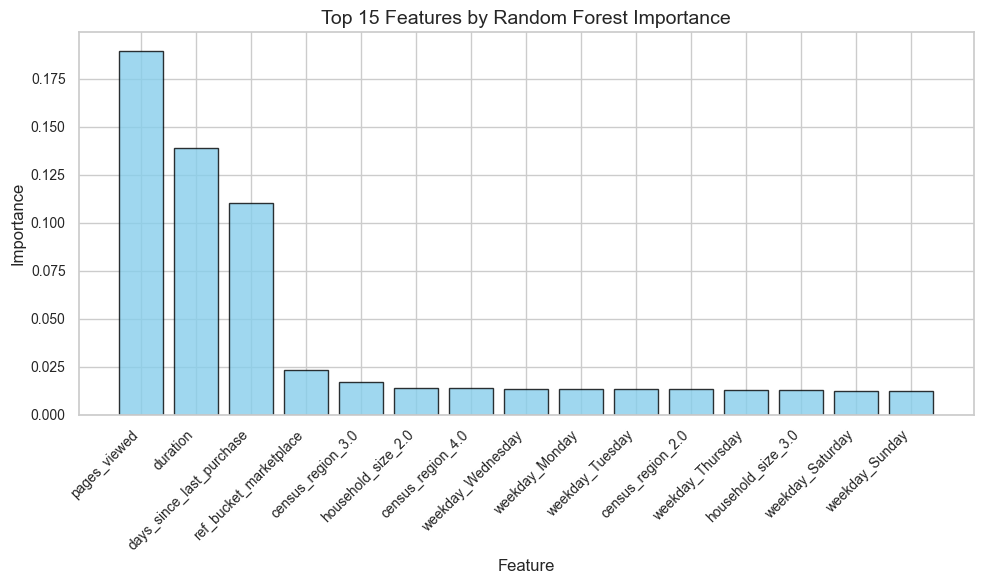

In [31]:

sns.set_theme(style="whitegrid")

top_features = feature_summary['rf_importance'].nlargest(15)

plt.figure(figsize=(10, 6))

plt.bar(top_features.index, top_features.values, color='skyblue', edgecolor='black', alpha=0.8)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.title('Top 15 Features by Random Forest Importance', fontsize=14)

plt.tight_layout()

plt.savefig("f_importance.png", dpi = 300)
plt.show()


### Feature Correlation

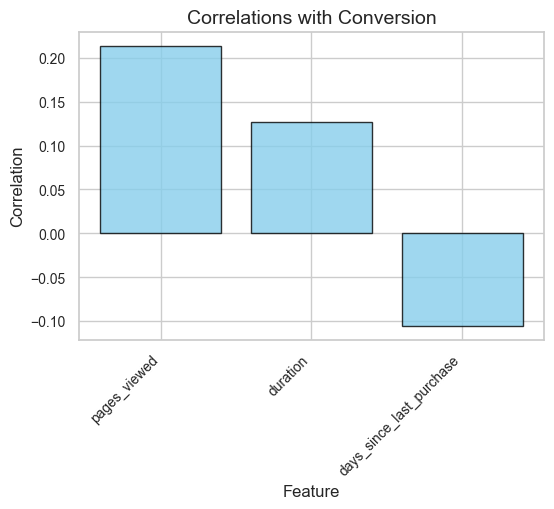

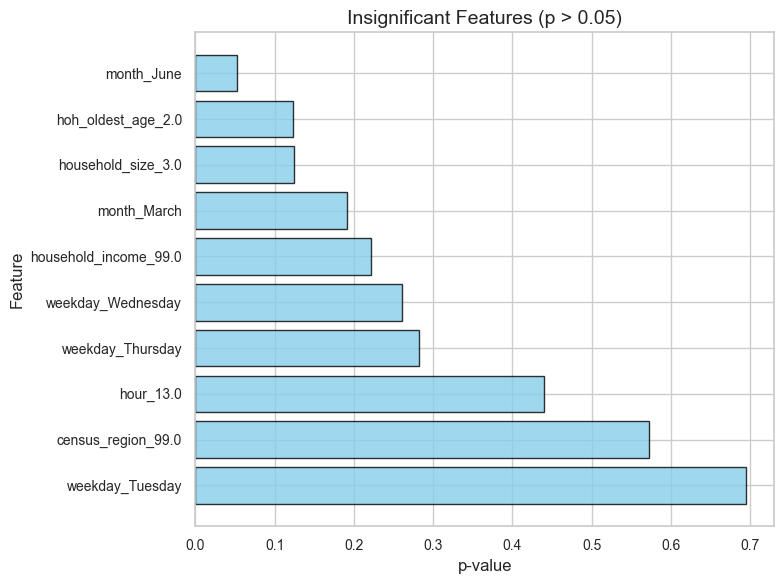

<Figure size 640x480 with 0 Axes>

In [32]:

sns.set_theme(style="whitegrid")

pos3 = feature_summary['correlation_with_target'].nlargest(5)

plt.figure(figsize=(6, 4))

plt.bar(pos3.index, pos3.values, color='skyblue', edgecolor='black', alpha=0.8)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlations with Conversion', fontsize=14)

import seaborn as sns

# Apply a clean, professional theme
sns.set_theme(style="whitegrid")

# Filter and sort insignificant features (p > 0.05)
insig = pvals[pvals > 0.05].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

plt.barh(insig.index, insig.values, color='skyblue', edgecolor='black', alpha=0.8)

plt.xlabel('p-value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Insignificant Features (p > 0.05)', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig("pvals.png", dpi =300)

plt.show()
plt.tight_layout()

plt.savefig("corelation.png", dpi = 300)
plt.show()


### Feature Significance

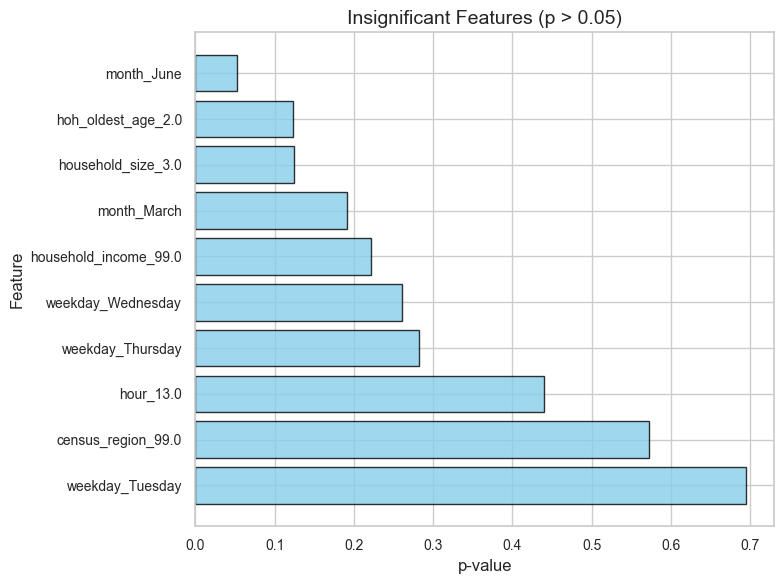

In [33]:
sns.set_theme(style="whitegrid")

insig = pvals[pvals > 0.05].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

plt.barh(insig.index, insig.values, color='skyblue', edgecolor='black', alpha=0.8)

plt.xlabel('p-value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Insignificant Features (p > 0.05)', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.savefig("pvals.png", dpi =300)

plt.show()


### Preparing Dataset for ML Model

In [34]:
model_df = df.copy()
df_enc = pd.get_dummies(model_df, columns=cat_cols, drop_first=True, dtype=float )

threshold = pd.Timestamp('2023-01-01')
train_df = df_enc[df_enc['event_date'] < threshold].copy()
test_df  = df_enc[df_enc['event_date'] >= threshold].copy()

In [35]:
model_df = df.copy()
df_enc = pd.get_dummies(model_df, columns=cat_cols, drop_first=True, dtype=float )

threshold = pd.Timestamp('2023-01-01')
train_df = df_enc[df_enc['event_date'] < threshold].copy()
test_df  = df_enc[df_enc['event_date'] >= threshold].copy()

In [36]:
train_df['converted'].value_counts()

converted
0    2993944
1     488469
Name: count, dtype: int64

In [37]:
test_df['converted'].value_counts()

converted
0    461045
1     52821
Name: count, dtype: int64

In [38]:
X_train = train_df.drop(columns=['machine_id',  'converted', 'event_date'])
y_train = train_df['converted']

X_test = test_df.drop(columns=['machine_id', 'converted', 'event_date'])
y_test = test_df['converted']

In [39]:
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])

### Comparing base models

In [40]:
models = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}


In [41]:
results = []
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    y_proba = m.predict_proba(X_test)[:,1] if hasattr(m,'predict_proba') else None
    results.append({
        'model': name,
        'roc_auc': roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    })

In [42]:
res_df = pd.DataFrame(results).set_index('model')
res_df

,roc_auc,accuracy,precision,recall,f1
model,,,,,
XGBoost,0.869272,0.897263,0.500616,0.215369,0.301171
Logistic Regression,0.795352,0.895298,0.436151,0.063497,0.110856
Random Forest,0.860523,0.896417,0.489726,0.183639,0.267115


In [43]:
best = res_df['roc_auc'].idxmax()
print("Best model:", best)

Best model: XGBoost


### Best Model -> XGBoost

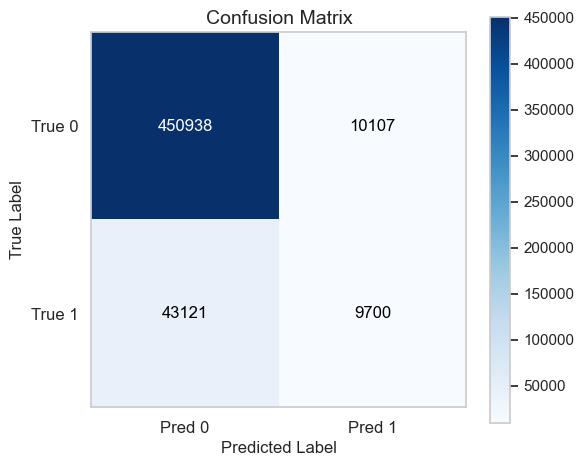

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Pred 0', 'Pred 1'], fontsize=12)
plt.yticks(tick_marks, ['True 0', 'True 1'], fontsize=12)

threshold = cm.max() / 2.0

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

plt.grid(False)

plt.tight_layout()
plt.show()


### Optimization (threshold)

In [45]:
scale = train_df.converted.value_counts()[0] / train_df.converted.value_counts()[1]

In [46]:
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale
)

In [47]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [48]:
probs = model.predict_proba(X_test)[:,1]
# pick threshold that maximizes F1 or gives desired recall

ths = np.linspace(0.1,0.9,81)
f1s = [f1_score(y_test, probs>t) for t in ths]
best_t = ths[np.argmax(f1s)]
print("Best threshold:", best_t)


Best threshold: 0.73


In [49]:
y_pred = (probs >= best_t).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92    461045
           1       0.37      0.59      0.45     52821

    accuracy                           0.85    513866
   macro avg       0.66      0.74      0.69    513866
weighted avg       0.89      0.85      0.87    513866



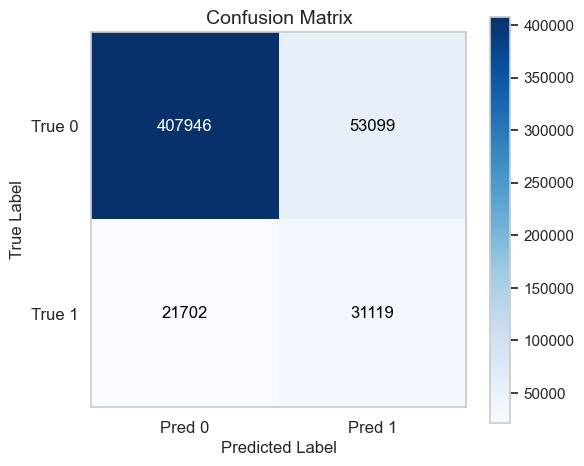

In [50]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=14)
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Pred 0', 'Pred 1'], fontsize=12)
plt.yticks(tick_marks, ['True 0', 'True 1'], fontsize=12)

threshold = cm.max() / 2.0

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 fontsize=12)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

plt.grid(False)

plt.tight_layout()
plt.savefig('confusion.png', dpi = 300)
plt.show()


In [51]:
print(f"roc auc score: {roc_auc_score(y_test, probs)}")
print(f"accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"precision score: {precision_score(y_test, y_pred)}")
print(f"recall score: {recall_score(y_test, y_pred)}")
print(f"f1 score: {f1_score(y_test, y_pred)}")

roc auc score: 0.8690425900236163
accuracy score: 0.8544348137452176
precision score: 0.3695053314018381
recall score: 0.5891406826830238
f1 score: 0.45416268361561307


### LIFT analysis

In [52]:

# after you have probs and y_test
lift_df = pd.DataFrame({
    'prob': probs,
    'actual': y_test.values  # or y_test if it’s an array
})

# 1. overall conversion rate
baseline_cr = lift_df['actual'].mean()

# 2. pick top 10% by model score
top_pct = 0.10
n_top = int(len(df) * top_pct)
lift_df_top = lift_df.nlargest(n_top, 'prob')

# 3. conversion rate in top 10%
top_cr = lift_df_top['actual'].mean()

# 4. lift
lift = top_cr / baseline_cr

print(f"Overall CR: {baseline_cr:.2%}")
print(f"Top 10% CR: {top_cr:.2%}")
print(f"Lift: {lift:.2f}×")


Overall CR: 10.28%
Top 10% CR: 13.17%
Lift: 1.28×


In [53]:
df_random = lift_df.sample(n_top, random_state=42)
print("Random 10% CR:", df_random['actual'].mean())

Random 10% CR: 0.10299103914400178


### AOV + incremental revenue calc.

In [54]:
transactions.columns

Index(['machine_id', 'site_session_id', 'prod_category_id', 'prod_name',
       'domain_id', 'prod_qty', 'prod_totprice', 'basket_tot', 'event_date',
       'event_time', 'domain_name', 'total_transactions_2020',
       'total_transactions_2021', 'total_transactions_2022',
       'total_transactions_2023'],
      dtype='object')

In [55]:
session_baskets = (
    transactions[['machine_id','event_date','domain_name','basket_tot']]
    .drop_duplicates(subset=['machine_id','event_date','domain_name'])
)

aov = (
    session_baskets
    .groupby('domain_name', as_index=False)['basket_tot']
    .mean()
    .rename(columns={'basket_tot':'AOV'})
)


In [56]:
aov

,domain_name,AOV
0,amazon.com,62.206553
1,ebay.com,65.333060
2,etsy.com,25.433020
3,target.com,79.635582
4,walmart.com,97.507052


In [57]:
N_amz = int(len(lift_df) * 0.10)

inc_orders_amz  = N_amz  * (top_cr  - baseline_cr)

inc_orders_amz

np.float64(1485.8995869365526)

In [58]:
# join in AOV
aov_amz  = aov.loc[aov.domain_name=='amazon.com','AOV'].iloc[0]
inc_rev_amz  = inc_orders_amz  * aov_amz
cost_amz  = N_amz  * 0.50
net_amz  = inc_rev_amz  - cost_amz
roi_amz  = net_amz  / cost_amz

In [59]:
roi_amz

np.float64(2.597582650796729)

### Parsimony Analysis

In [60]:
X_train_par = X_train[num_cols]
X_test_par = X_test[num_cols]

In [61]:
model_par = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale
)

In [62]:
model_par.fit(X_train_par, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [63]:
probs_par = model_par.predict_proba(X_test_par)[:,1]
# pick threshold that maximizes F1 or gives desired recall

ths = np.linspace(0.1,0.9,81)
f1s_par = [f1_score(y_test, probs_par>t) for t in ths]
best_t_par = ths[np.argmax(f1s_par)]
print("Best threshold:", best_t_par)


Best threshold: 0.6799999999999999


In [64]:
y_pred_par = (probs_par >= best_t_par).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_par))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89    461045
           1       0.30      0.63      0.41     52821

    accuracy                           0.81    513866
   macro avg       0.63      0.73      0.65    513866
weighted avg       0.88      0.81      0.84    513866



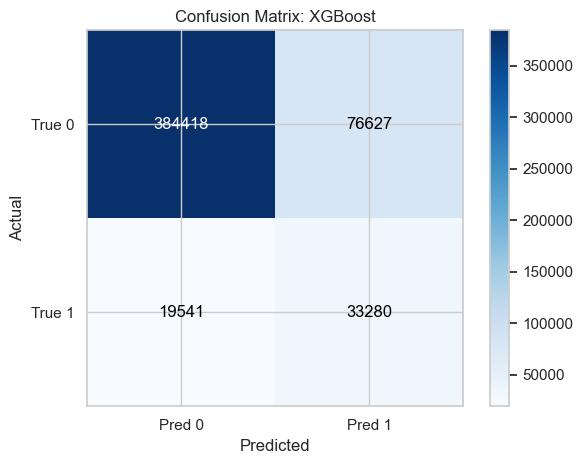

In [65]:
cm = confusion_matrix(y_test, y_pred_par)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.title(f'Confusion Matrix: {best}')
plt.colorbar()
plt.xticks([0,1], ['Pred 0','Pred 1'])
plt.yticks([0,1], ['True 0','True 1'])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [66]:
print(f"roc auc score: {roc_auc_score(y_test, probs_par)}")
print(f"accuracy score: {accuracy_score(y_test, y_pred_par)}")
print(f"precision score: {precision_score(y_test, y_pred_par)}")
print(f"recall score: {recall_score(y_test, y_pred_par)}")
print(f"f1 score: {f1_score(y_test, y_pred_par)}")

roc auc score: 0.8429575665148897
accuracy score: 0.812853934683361
precision score: 0.3028014594156878
recall score: 0.6300524412638913
f1 score: 0.40902610491126296


### Transfer prediction on other domains 

#### preprocessing

In [67]:
s_mach_nonamz = sessions_non_amz['machine_id'].unique().tolist()
t_mach_nonamz = transactions_non_amz['machine_id'].unique().tolist()

In [68]:
sessions_non_amz = sessions_non_amz[sessions_non_amz['machine_id'].isin(t_mach_nonamz)]

In [69]:
sessions_non_amz['ref_bucket'] = sessions_non_amz['ref_domain__name'].apply(bucket_ref)

In [70]:
# extract hour and weekday
sessions_non_amz['event_date'] = pd.to_datetime(sessions_non_amz['event_date'])

# extract hour by splitting on ':' and converting to int
sessions_non_amz['event_time_parsed'] = pd.to_datetime(
    sessions_non_amz['event_time'],
    format='%H:%M:%S',
    errors='coerce'            # invalid/missing → NaT
)
sessions_non_amz['hour'] = sessions_non_amz['event_time_parsed'].dt.hour

# extract weekday name
sessions_non_amz['weekday'] = sessions_non_amz['event_date'].dt.day_name()


# extract month name
sessions_non_amz['month'] = sessions_non_amz['event_date'].dt.month_name()

In [71]:
sessions_nonamz_agg = sessions_non_amz.groupby(['machine_id','event_date']).agg(
    pages_viewed       = ('pages_viewed',       'sum'),
    duration           = ('duration',           'sum'),
    hoh_most_education = ('hoh_most_education', 'first'),
    census_region      = ('census_region',      'first'),
    household_size     = ('household_size',     'first'),
    hoh_oldest_age     = ('hoh_oldest_age',     'first'),
    household_income   = ('household_income',   'first'),
    children           = ('children',           'first'),
    hour = ('hour', 'first'),
    month = ('month', 'first'),
    weekday = ('weekday', 'first'),
    ref_bucket=('ref_bucket', 'first')
).reset_index()

In [72]:
trans_nonamz_agg = (
    transactions_non_amz
    .groupby(['machine_id','event_date'])
    .size()
    .reset_index(name='converted')
)
trans_nonamz_agg['converted'] = 1

In [73]:
df_nonamz = sessions_nonamz_agg.merge(
    trans_nonamz_agg, 
    on=['machine_id','event_date'], 
    how='left'
)
df_nonamz['converted'] = df_nonamz['converted'].fillna(0).astype(int)

In [74]:
df_nonamz = df_nonamz.sort_values(['machine_id','event_date'])

df_nonamz = df_nonamz.groupby('machine_id').apply(compute_days_since_last).reset_index(drop=True)


In [75]:
df_nonamz['hoh_most_education'].fillna(99, inplace=True)
df_nonamz['census_region'].fillna(99, inplace=True)
df_nonamz['household_size'].fillna(99, inplace=True)
df_nonamz['hoh_oldest_age'].fillna(99, inplace=True)
df_nonamz['household_income'].fillna(99, inplace=True)

In [76]:
df_nonamz['hoh_most_education'] = df_nonamz['hoh_most_education'].replace(-88, 99)
df_nonamz['household_size'] = df_nonamz['household_size'].replace(-88, 99)

In [77]:
df_nonamz = df_nonamz.dropna().reset_index(drop=True)

In [78]:
df_nonamz.isna().sum()

machine_id                  0
event_date                  0
pages_viewed                0
duration                    0
hoh_most_education          0
census_region               0
household_size              0
hoh_oldest_age              0
household_income            0
children                    0
hour                        0
month                       0
weekday                     0
ref_bucket                  0
converted                   0
days_since_last_purchase    0
dtype: int64

In [79]:
df_nonamz['converted'].value_counts()

converted
0    1970708
1     227170
Name: count, dtype: int64

In [80]:
model_nonamz_df = df_nonamz.copy()

In [81]:
X_nonamz_test = model_nonamz_df.drop(columns=['machine_id', 'converted', 'event_date'])
y_nonamze_test = model_nonamz_df['converted']

In [82]:
X_nonamz_test = pd.get_dummies(X_nonamz_test, columns=cat_cols, drop_first=True, dtype=float )
X_nonamz_test[num_cols]  = scaler.transform(X_nonamz_test[num_cols])

In [83]:
probs_nonamz = model.predict_proba(X_nonamz_test)[:,1]
# pick threshold that maximizes F1 or gives desired recall

ths = np.linspace(0.1,0.9,81)
f1s_nonamz = [f1_score(y_nonamze_test, probs_nonamz>t) for t in ths]
best_t_nonamz = ths[np.argmax(f1s_nonamz)]
print("Best threshold:", best_t_nonamz)


Best threshold: 0.61


In [84]:
y_pred_nonamz = (probs_nonamz >= best_t_nonamz).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_nonamze_test, y_pred_nonamz))

              precision    recall  f1-score   support

           0       0.94      0.80      0.86   1970708
           1       0.25      0.60      0.35    227170

    accuracy                           0.78   2197878
   macro avg       0.60      0.70      0.61   2197878
weighted avg       0.87      0.78      0.81   2197878



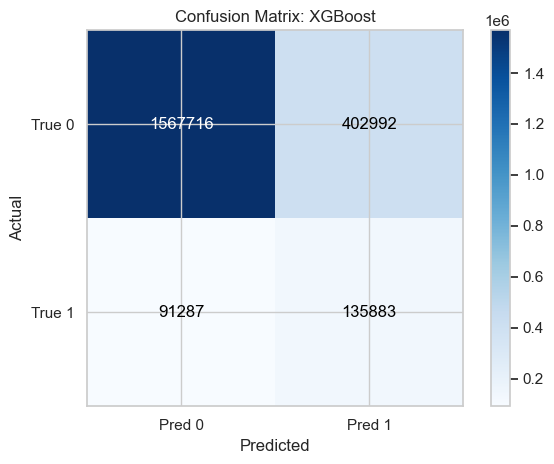

In [85]:
cm = confusion_matrix(y_nonamze_test, y_pred_nonamz)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.title(f'Confusion Matrix: {best}')
plt.colorbar()
plt.xticks([0,1], ['Pred 0','Pred 1'])
plt.yticks([0,1], ['True 0','True 1'])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#### parsimony prediction

In [86]:
X_nonamz_test_par = X_nonamz_test[num_cols]

In [87]:
probs_nonamz_par = model_par.predict_proba(X_nonamz_test_par)[:,1]
# pick threshold that maximizes F1 or gives desired recall

ths = np.linspace(0.1,0.9,81)
f1s_nonamz_par = [f1_score(y_nonamze_test, probs_nonamz_par>t) for t in ths]
best_t_nonamz_par = ths[np.argmax(f1s_nonamz_par)]
print("Best threshold:", best_t_nonamz_par)


Best threshold: 0.66


In [88]:
y_pred_nonamz_par = (probs_nonamz_par >= best_t_nonamz_par).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_nonamze_test, y_pred_nonamz_par))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87   1970708
           1       0.26      0.58      0.36    227170

    accuracy                           0.79   2197878
   macro avg       0.60      0.70      0.62   2197878
weighted avg       0.87      0.79      0.82   2197878



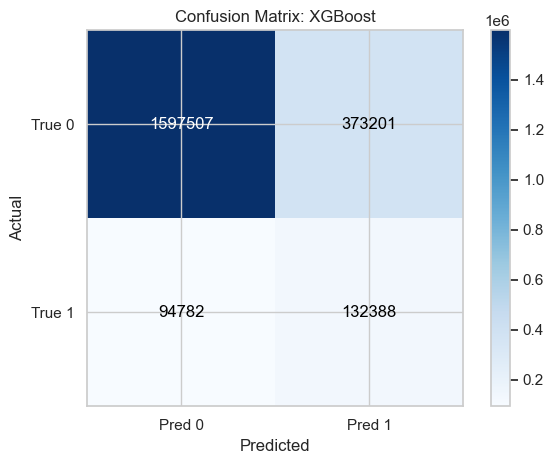

In [89]:
cm = confusion_matrix(y_nonamze_test, y_pred_nonamz_par)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.title(f'Confusion Matrix: {best}')
plt.colorbar()
plt.xticks([0,1], ['Pred 0','Pred 1'])
plt.yticks([0,1], ['True 0','True 1'])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center',
                 color='white' if cm[i,j] > cm.max()/2 else 'black')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()